# Setup

In [43]:
import numpy as np
from sklearn.datasets import make_regression, make_classification
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression, LogisticRegression
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import os

pd.options.mode.chained_assignment = None

In [2]:
x, y = make_regression(22000, n_features=10, n_informative=10, noise=10, random_state=0)
np.savetxt("synthetic.csv", np.concatenate([x, y[:, None]], axis=-1), delimiter=",", header=",".join([f"dim_{i}" for i in range(10)] + ["label"]))

x_1 = np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)
x_1.shape

(22000, 11)

In [3]:
def ols(x_1, y):
    reg = LinearRegression(fit_intercept=False).fit(x_1, y)
    return reg.coef_

In [4]:
def rmse(y_hat, y):
    return np.sqrt(((y_hat - y) ** 2).mean())

In [5]:
def r_squared(predictions, labels):
    """
    Taken from official repository https://github.com/google-research/google-research/tree/master/dp_regression.
    Gives different R2 scores than those of sklearn.metrics.r2_score,
    therefore we need to use this function to compare our results fairly
    to those of the paper.
    """
    sum_squared_residuals = np.sum(np.square(predictions - labels))
    total_sum_squares = np.sum(np.square(labels - np.mean(labels)))
    return 1 - np.divide(sum_squared_residuals, total_sum_squares)

In [6]:
beta_ols = ols(x_1, y)
print(beta_ols.shape)
y_hat_ols = x_1 @ beta_ols

rmse(y_hat_ols, y), r_squared(y_hat_ols, y)

(11,)


(9.977192409407028, 0.9968007733594516)

# Step-by-step implementation

In [7]:
# Get m splits
m = 1000

kf = KFold(n_splits=m, shuffle=True)
beta_list = []
rmse_list = []

for i, (train_idx, test_idx) in enumerate(kf.split(x_1)):
    beta_split = ols(x_1[test_idx], y[test_idx])
    beta_list.append(beta_split)
    rmse_list.append(rmse(x_1[test_idx] @ beta_split, y[test_idx]))

beta_list = np.array(beta_list)
print(rmse_list)

[6.361947038442489, 5.569556412927472, 4.812432303656288, 9.572836823365469, 8.207678477202668, 8.640766967356194, 6.47619513477427, 7.617318426066305, 10.463367936391563, 7.393486122029633, 5.6061474786929875, 5.86792842973358, 6.87856898954793, 5.599266071799979, 6.987165687815952, 5.27538607609747, 7.12327989457117, 9.879630593121096, 10.025094742897405, 5.582548410420205, 2.543547067597395, 6.2975198582916105, 8.678950581935448, 5.704096007383398, 8.043871155365435, 6.968476088514332, 6.235672302594111, 7.827770558484802, 6.639968184898006, 8.172511081588958, 9.17968086333399, 6.830128902039604, 4.994021694807376, 4.552570678339995, 6.657618703240788, 7.519208539844033, 5.759355776540062, 5.427796165950153, 9.13877921220537, 7.07761681851023, 8.896958514039135, 6.351664673872687, 8.766029570578434, 6.192227526949277, 6.1477454571043815, 7.656009749909539, 4.250198396737106, 4.621626599752954, 5.807529227505408, 8.894058997326633, 6.370626830059107, 4.82986960745338, 5.1272851171835

In [8]:
beta_list.shape

(1000, 11)

In [9]:
S = np.zeros((x_1.shape[1], m))

for j in range(x_1.shape[1]):
    S[j, :] = np.sort(beta_list[:, j])

S[:3], S.shape

(array([[46.64010625, 51.73675294, 51.96577187, ..., 72.02471018,
         72.33643036, 76.55962694],
        [43.99302764, 44.54210185, 44.79995994, ..., 65.16852279,
         67.32963283, 68.83763356],
        [44.15396597, 46.1028986 , 46.93893476, ..., 65.47913413,
         65.51772367, 67.40454572]]),
 (11, 1000))

In [10]:
log_vol_list = []

for i in range(m // 2):
    temp = np.log(S[:, m - i - 1] - S[:, i])
    log_vol_list.append(temp.sum())

print(log_vol_list)

[35.3616859838798, 33.2652283428797, 32.62308011796526, 32.05259559802049, 31.571107551724737, 31.109826442517743, 30.769206985589378, 30.53479137306997, 30.378806221130887, 30.06890330264102, 29.86615897130755, 29.61778752759317, 29.44238938069044, 29.30748801656631, 29.155251711994005, 29.012508877811566, 28.91412609799653, 28.776926462714094, 28.581787490600753, 28.486515995782188, 28.359706880347826, 28.275877875544623, 28.190581281789395, 28.086070196438577, 27.984009407927182, 27.896292991614004, 27.774365719913487, 27.641708714391143, 27.533107563483718, 27.46163469295256, 27.37297233739307, 27.256711861819472, 27.118107850679028, 27.032916521764008, 26.94028897955571, 26.85007068966114, 26.736487324486724, 26.64792401697141, 26.553670892299497, 26.454347760886673, 26.36914749954846, 26.286735865564918, 26.22571354736706, 26.1488625919523, 26.091729465471325, 26.015003403887594, 25.950882436941495, 25.839661905207578, 25.792311661547785, 25.74397950171898, 25.645609864050513, 25

In [11]:
def compute_k(log_volumes: list[int], epsilon: float, delta: float) -> int:
    l = len(log_volumes)
    t = l // 2

    log_threshold = np.log(delta / (8 * np.exp(epsilon)))

    for k in range(t - 2, -1, -1):
        for g in range(1, l - t - k):
            if log_volumes[t - k - 2] - log_volumes[t + k + g] - epsilon * g / 2 <= log_threshold:
                return k
    return -1

In [12]:
compute_k(log_vol_list, np.log(3), 1e-5)

137

In [13]:
def ptr_check(log_volumes, epsilon, delta):
    k = compute_k(log_volumes, epsilon, delta)
    return k + np.random.laplace(scale=epsilon) >= np.log(1 / (2 * delta)) / epsilon

In [14]:
ptr_check(log_vol_list, np.log(3) / 2, 1e-5)

True

In [15]:
def sample_from_intervals(interval1, interval2, size=1):
    """
    Samples uniformly from the union of two intervals.

    Parameters:
        interval1 (tuple): First interval in the form (a, b) where b > a.
        interval2 (tuple): Second interval in the form (a, b) where b > a.
        size (int): Number of samples to generate.

    Returns:
        np.ndarray: Array of samples.
    """
    # Calculate the lengths of the intervals
    length1 = interval1[1] - interval1[0]
    length2 = interval2[1] - interval2[0]

    # Total length of the intervals
    total_length = length1 + length2

    # Generate uniform samples from 0 to total_length
    samples = np.random.uniform(0, total_length, size=size)

    # Adjust samples to map to the union of intervals
    # Samples that fall within the length of the first interval are adjusted to interval1
    # Samples that fall outside are adjusted to interval2
    samples_adjusted = np.where(samples <= length1,
                                interval1[0] + samples,
                                interval2[0] + samples - length1)

    return samples_adjusted

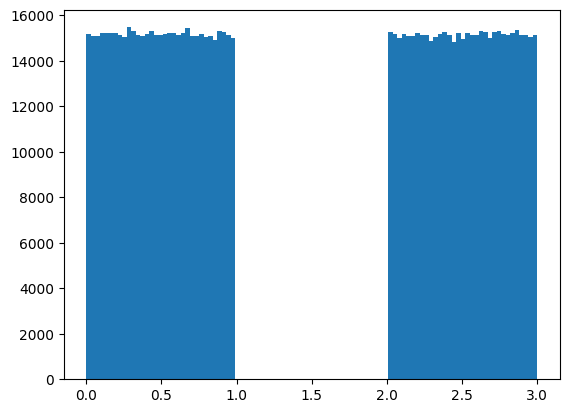

In [16]:
plt.hist(sample_from_intervals((0, 1-1e-2), (2+1e-2, 3), size=1000000), bins=100)
plt.show()

In [17]:
def sample_point_with_depth(sorted_estimators, depth):
    d, m = sorted_estimators.shape
    i = depth

    vol_i = sorted_estimators[:, m - i - 1] - sorted_estimators[:, i]
    vol_ip1 = sorted_estimators[:, m - i - 2] - sorted_estimators[:, i + 1]
    w_i = vol_i - vol_ip1

    vol_geq1_i = np.prod(vol_i)

    vol_c_list = np.zeros(shape=(d,))

    for j in range(d):
        v_less = np.prod(vol_ip1[:j])
        v_more = np.prod(vol_i[j + 1:])
        vol_c_list[j] = v_less * w_i[j] * v_more

    probs = vol_c_list / vol_geq1_i
    probs /= probs.sum()

    j_star = np.random.choice(d, p=probs)

    y = np.zeros(shape=(d,))

    for j in range(j_star):
        y[j] = np.random.uniform(low=sorted_estimators[j, i + 1], high=sorted_estimators[j, m - i - 2])

    l_interval = (sorted_estimators[j_star, i], sorted_estimators[j_star, i + 1])
    r_interval = (sorted_estimators[j_star, m - i - 2], sorted_estimators[j_star, m - i - 1])

    y[j_star] = sample_from_intervals(l_interval, r_interval)[0]

    for j in range(j_star + 1, d):
        y[j] = np.random.uniform(low=sorted_estimators[j, i], high=sorted_estimators[j, m - i - 1])

    return y

In [18]:
sample_point_with_depth(S, 467) - beta_ols

array([ 0.03411919, -0.0652963 ,  0.33434358, -0.28635808, -0.21906769,
       -0.26266145,  0.35134238, -0.00587621,  0.19308372, -0.04674228,
        0.08833201])

In [19]:
def restricted_tukey_em(log_volumes, sorted_estimators, t, epsilon):
    depth_list = np.arange(t, len(log_volumes)) - 1

    w = np.exp(log_volumes)[:-1] - np.exp(log_volumes)[1:]

    probs = w[depth_list[0]:] * np.exp(epsilon * depth_list)
    probs /= probs.sum()

    depth = np.random.choice(depth_list, p=probs)

    return sample_point_with_depth(sorted_estimators, depth)

In [20]:
restricted_tukey_em(log_vol_list, S, len(log_vol_list) // 2, np.log(3)) - beta_ols

array([-0.16720081,  0.01849222,  0.01718208, -0.12808306, -0.08356713,
       -0.02212001,  0.1241906 ,  0.07918857,  0.11476781, -0.10160877,
       -0.00366412])

In [21]:
beta_tukey_em = restricted_tukey_em(log_vol_list, S, len(log_vol_list) // 2, np.log(3))
y_hat_tukey_em = x_1 @ beta_tukey_em

r_squared(y_hat_tukey_em, y)

0.996796927728409

# Single function algorithm

In [22]:
def tukey_em(x_1, y, m, eps, delta):
    # Evenly and randomly partition x and y into subsets
    kf = KFold(n_splits=m, shuffle=True)
    beta_list = []

    # Compute m OLS estimators
    for i, (train_idx, test_idx) in enumerate(kf.split(x_1)):
        beta_split = ols(x_1[test_idx], y[test_idx])
        beta_list.append(beta_split)

    beta_list = np.array(beta_list)
    beta_list = beta_list + np.random.normal(loc=0., scale=0.001, size=beta_list.shape)

    # Compute sorted estimators
    S = np.zeros((x_1.shape[1], m))

    for j in range(x_1.shape[1]):
        S[j, :] = np.sort(beta_list[:, j])

    # Compute region volumes
    log_vol_list = []

    for i in range(m // 2):
        temp = np.log(S[:, m - i - 1] - S[:, i])
        log_vol_list.append(temp.sum())

    # Perform PTR check and return estimator
    if ptr_check(log_vol_list, eps / 2, delta):
        return restricted_tukey_em(log_vol_list, S, m // 4, eps / 2)

    return None

In [23]:
m = 1000
eps = np.log(3)
delta = 1e-5

beta_tukey_em = tukey_em(x_1, y, m, eps, delta)
y_hat_tukey_em = x_1 @ beta_tukey_em

rmse(y_hat_tukey_em, y), r_squared(y_hat_tukey_em, y)

(9.98211348392807, 0.9967976166567046)

# Experiments

In [24]:
def feature_selection(dataset):
    """
    Feature selection equal to that of https://github.com/google-research/google-research/tree/master/dp_regression,
    to ensure consistent results.

    Links are given to download each dataset.
    Rename csv files accordingly.
    """
    data = pd.read_csv(dataset, skipinitialspace=False, encoding='unicode_escape')

    x, y = None, None
    reported_ols_r2, reported_tukey_em_r2 = None, None
    n_trials = 10

    if dataset == "synthetic.csv":
        data = data.values
        x, y = data[:, :-1], data[:, -1]

        reported_ols_r2 = 0.997
        reported_tukey_em_r2 = 0.997
    elif dataset == "california.csv":
        # California dataset: https://www.kaggle.com/datasets/camnugent/california-housing-prices/

        data.dropna(inplace = True)
        data = data.to_numpy()[:,:-1].astype(np.float32)
        x = data[:, :-1]
        y = data[:, -1]

        reported_ols_r2 = 0.637
        reported_tukey_em_r2 = 0.099

        n_trials = 50
    elif dataset == "diamonds.csv":
        # Diamonds dataset: https://www.kaggle.com/datasets/shivam2503/diamonds

        data.dropna(inplace = True)
        y = data["price"].to_numpy()
        data = data.drop("price", axis=1)
        data = data.replace(
            to_replace=["Fair", "Good", "Very Good", "Premium", "Ideal"],
            value=[1, 2, 3, 4, 5])
        data = data.replace(
            to_replace=["J", "I", "H", "G", "F", "E", "D"], value=[1, 2, 3, 4, 5, 6, 7])
        data = data.replace(
            to_replace=["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"],
            value=[1, 2, 3, 4, 5, 6, 7, 8])
        data = data.drop("Unnamed: 0", axis=1)
        x = data.to_numpy()

        reported_ols_r2 = 0.907
        reported_tukey_em_r2 = 0.307

        n_trials = 50
    elif dataset == "traffic.csv":
        # Traffic dataset: https://data.ny.gov/stories/s/Weigh-In-Motion-Station-Vehicle-Traffic-Counts-201/gdpg-i86w
        data = data[["Class 1", "Class 2", "Class 3"]]
        data.dropna(inplace = True)
        y = data["Class 2"].to_numpy()
        x = data[["Class 1", "Class 3"]].to_numpy()

        reported_ols_r2 = 0.966
        reported_tukey_em_r2 = 0.965
    elif dataset == "nba.csv":
        # NBA dataset: https://www.kaggle.com/datasets/nathanlauga/nba-games?select=games.csv
        data = data[[
            "PTS_home", "FT_PCT_home", "FG3_PCT_home", "FG_PCT_home", "AST_home",
            "REB_home"
        ]]
        data.dropna(inplace = True)
        y = data["PTS_home"].to_numpy()
        x = data[[
            "FT_PCT_home", "FG3_PCT_home", "FG_PCT_home", "AST_home", "REB_home"
        ]].to_numpy()

        reported_ols_r2 = 0.621
        reported_tukey_em_r2 = 0.618
    elif dataset == "mlb.csv":
        # MLB dataset: https://www.kaggle.com/datasets/samaxtech/mlb-games-data-from-retrosheet

        fts = ["v_strikeouts", "v_walks", "v_pitchers_used",
                "v_errors", "h_at_bats", "h_hits", "h_doubles",
                "h_triples", "h_homeruns", "h_stolen_bases",
                "h_score"]

        data = data[fts]
        data.dropna(inplace = True)
        y = data["h_score"].to_numpy().astype(np.float32)
        data = data.drop("h_score", axis=1)
        x = data.to_numpy()

        reported_ols_r2 = 0.722
        reported_tukey_em_r2 = 0.721
    elif dataset == "garbage.csv":
        # Garbage dataset: https://data.cityofnewyork.us/City-Government/DSNY-Monthly-Tonnage-Data/ebb7-mvp5/about_data

        fts = ["BOROUGH", "PAPERTONSCOLLECTED", "MGPTONSCOLLECTED", "REFUSETONSCOLLECTED"]
        data = data[fts]

        data.dropna(inplace = True)
        y = data["REFUSETONSCOLLECTED"].to_numpy().astype(np.float32)
        data = data.drop("REFUSETONSCOLLECTED", axis=1)
        borough = pd.get_dummies(data["BOROUGH"], prefix="BOROUGH")
        data = data.drop("BOROUGH", axis=1)
        data = data.join(borough)
        x = data.to_numpy().astype(np.float32)
    elif dataset == "beijing.csv":
        # Beijing dataset: https://www.kaggle.com/datasets/ruiqurm/lianjia?resource=download

        fts = ["DOM", "followers", "totalPrice",
                "square", "kitchen", "buildingType",
                "renovationCondition",
                "buildingStructure", "ladderRatio",
                "elevator", "fiveYearsProperty",
                "subway", "district",
                "communityAverage"]

        data = data[fts]
        data.dropna(inplace = True)
        data = data.drop([60422])

        building_type = pd.get_dummies(data["buildingType"], prefix="buildingType", dtype=float)
        data = data.drop("buildingType", axis=1)
        data = data.join(building_type)

        renovation_condition = pd.get_dummies(
            data["renovationCondition"], prefix="renovationCondition", dtype=float)
        data = data.drop("renovationCondition", axis=1)
        data = data.join(renovation_condition)

        building_structure = pd.get_dummies(data["buildingStructure"], prefix="buildingStructure", dtype=float)
        data = data.drop("buildingStructure", axis = 1)
        data = data.join(building_structure)

        y = data["totalPrice"].to_numpy()
        data = data.drop("totalPrice", axis=1)
        x = data.to_numpy()

        reported_ols_r2 = 0.702
        reported_tukey_em_r2 = 0.698
    else:
        raise Exception("Invalid dataset.")


    x_1 = np.column_stack([x, np.ones(x.shape[0])]).astype(float)

    return (x_1, y), (reported_ols_r2, reported_tukey_em_r2), n_trials

In [25]:
def experiment(dataset, m=1000, eps=np.log(3), delta=1e-5, verbose=True):
    (x_1, y), (reported_ols_r2, reported_tukey_em_r2), n_trials = feature_selection(dataset)

    beta_ols = ols(x_1, y)
    y_hat_ols = x_1 @ beta_ols

    our_ols_r2 = r_squared(y_hat_ols, y)

    r2_list = []

    with tqdm(range(n_trials), desc=f"{dataset}, data shape {x_1.shape}", disable=not verbose) as pbar:
        for i in pbar:
            beta_tukey_em = tukey_em(x_1, y, m, eps, delta)
            y_hat_tukey_em = x_1 @ beta_tukey_em

            r2_list.append(r_squared(y_hat_tukey_em, y))

            pbar.set_postfix({"median_r2": np.median(r2_list), "std_r2": np.std(r2_list)})

    our_tukey_em_r2 = np.median(r2_list)


    return r2_list, (our_ols_r2, reported_ols_r2), (our_tukey_em_r2, reported_tukey_em_r2), n_trials

In [26]:
csv_files = [file_name for file_name in os.listdir() if file_name.endswith(".csv")]

for dataset in csv_files:
    print("-----------------------------------------------------")

    # m = 1500 if dataset.startswith("beijing") else 1000
    r2_list, (our_ols_r2, reported_ols_r2), (our_tukey_em_r2, reported_tukey_em_r2), n_trials = experiment(dataset)

    print(f"\n     Our OLS R2 Score: {our_ols_r2:.3f}")
    if reported_ols_r2 is not None:
        print(f"Reported OLS R2 Score: {reported_ols_r2}")
    print("")
    print(f"     Our TukeyEM R2 Score: {our_tukey_em_r2:.3f}")
    if reported_tukey_em_r2 is not None:
        print(f"Reported TukeyEM R2 Score: {reported_tukey_em_r2}\n")

-----------------------------------------------------


synthetic.csv, data shape (22000, 11): 100%|██████████| 10/10 [00:33<00:00,  3.30s/it, median_r2=0.997, std_r2=2.59e-6]


     Our OLS R2 Score: 0.997
Reported OLS R2 Score: 0.997

     Our TukeyEM R2 Score: 0.997
Reported TukeyEM R2 Score: 0.997



In [27]:
m_list = [800, 1000, 1200, 1400, 1600, 1800]

for dataset in csv_files:
    if dataset != "traffic.csv":
        continue

    median_r2_per_m = np.zeros(shape=(len(m_list)))
    std_r2_per_m = np.zeros(shape=(len(m_list)))

    for i, m in enumerate(m_list):
        r2_list, (our_ols_r2, reported_ols_r2), (our_tukey_em_r2, reported_tukey_em_r2), n_trials = experiment(dataset, m=m)
        median_r2_per_m[i] = np.median(r2_list)
        std_r2_per_m[i] = np.std(r2_list)

    plt.plot(m_list, median_r2_per_m, label="TukeyEM")
    plt.plot(m_list, our_ols_r2 * np.ones(shape=(len(m_list))), label="NonDP")
    plt.fill_between(m_list, median_r2_per_m - std_r2_per_m, median_r2_per_m + std_r2_per_m, alpha = 0.2)
    plt.legend()
    plt.ylabel(f"$R^2$ from {n_trials} trials")
    plt.xlabel("# models m")
    plt.grid()
    plt.show()

# Tukey Depth Experiments

Toy experiment (as shown in the paper's appendix) to debug `sample_point_with_depth` function, which tries to uniformly sample a point from a region with a given approximate Tukey depth.

In [28]:
p_1 = np.array([1, 7, 5, 3, 5, 6])
p_1 = p_1 + np.random.normal(loc=0., scale=0.01, size=p_1.shape)
p_2 = np.array([1, 3, 7, 3, 5, 3])
p_2 = p_2 + np.random.normal(loc=0., scale=0.01, size=p_1.shape)

test_S = np.zeros([2, 6])
test_S[0, :] = np.sort(p_1)
test_S[1, :] = np.sort(p_2)

test_S

array([[0.99770489, 3.00304496, 5.00148305, 5.00268308, 6.00118204,
        7.00012074],
       [1.01092969, 2.99913373, 3.00164175, 3.01060504, 4.9887402 ,
        7.00598677]])

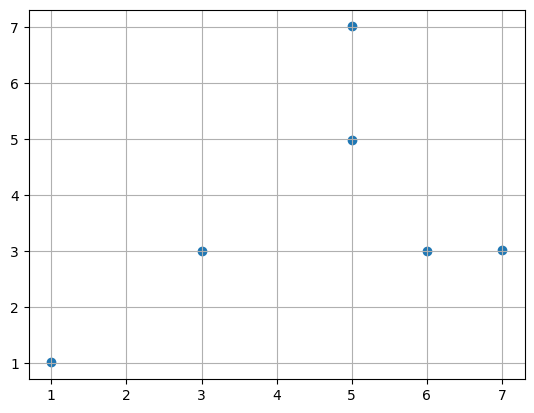

In [29]:
plt.scatter(p_1, p_2)
plt.grid()
plt.show()

In [30]:
n_samples = 1000

samples_depth_2 = np.zeros(shape=(n_samples, 2))
samples_depth_1 = np.zeros(shape=(n_samples, 2))
for i in range(n_samples):
    samples_depth_2[i, :] = sample_point_with_depth(test_S, 1)
    samples_depth_1[i, :] = sample_point_with_depth(test_S, 0)

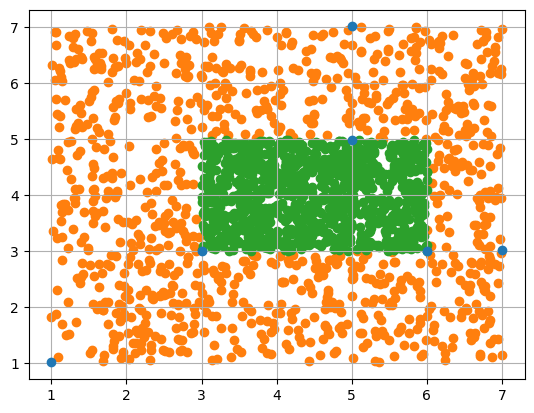

In [31]:
plt.scatter(p_1, p_2, zorder=3)

plt.scatter(samples_depth_1[:, 0], samples_depth_1[:, 1])
plt.scatter(samples_depth_2[:, 0], samples_depth_2[:, 1])

plt.grid()
plt.show()

# Logistic Regression

In [36]:
x, y = make_classification(n_samples=22000, n_features=10, n_informative=10, n_redundant=0, n_classes=2)

x_1 = np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)
x_1.shape

(22000, 11)

In [41]:
log_reg = LogisticRegression(fit_intercept=False).fit(x_1, y)
log_reg.coef_[0]

array([ 0.88909105,  0.64169964, -0.87402532, -0.831908  ,  0.18559391,
       -0.66120327,  0.45506911,  0.20442082,  0.4172587 ,  0.31545379,
        0.91980415])

In [44]:
def tukey_em_logistic(x_1, y, m, eps, delta):
    # Evenly and randomly partition x and y into subsets
    kf = KFold(n_splits=m, shuffle=True)
    beta_list = []

    # Compute m OLS estimators
    for i, (train_idx, test_idx) in enumerate(kf.split(x_1)):
        log_reg = LogisticRegression(fit_intercept=False).fit(x_1[test_idx], y[test_idx])
        beta_split = log_reg.coef_[0]
        beta_list.append(beta_split)

    beta_list = np.array(beta_list)
    beta_list = beta_list + np.random.normal(loc=0., scale=0.001, size=beta_list.shape)

    # Compute sorted estimators
    S = np.zeros((x_1.shape[1], m))

    for j in range(x_1.shape[1]):
        S[j, :] = np.sort(beta_list[:, j])

    # Compute region volumes
    log_vol_list = []

    for i in range(m // 2):
        temp = np.log(S[:, m - i - 1] - S[:, i])
        log_vol_list.append(temp.sum())

    # Perform PTR check and return estimator
    if ptr_check(log_vol_list, eps / 2, delta):
        return restricted_tukey_em(log_vol_list, S, m // 4, eps / 2)

    return None

In [47]:
def experiment_logistic(x_1, y, n_trials=10, m=1000, eps=np.log(3), delta=1e-5, verbose=True):
    log_reg = LogisticRegression(fit_intercept=False).fit(x_1, y)
    beta_log = log_reg.coef_[0]
    y_hat_log = x_1 @ beta_log

    our_log_auc = roc_auc_score(y, y_hat_log)

    auc_list = []

    with tqdm(range(n_trials), desc=f"{dataset}, data shape {x_1.shape}", disable=not verbose) as pbar:
        for i in pbar:
            beta_tukey_em = tukey_em_logistic(x_1, y, m, eps, delta)
            y_hat_tukey_em = x_1 @ beta_tukey_em

            auc_list.append(roc_auc_score(y, y_hat_tukey_em))

            pbar.set_postfix({"median_r2": np.median(auc_list), "std_r2": np.std(auc_list)})

    our_tukey_em_auc = np.median(auc_list)

    return auc_list, our_log_auc, our_tukey_em_auc, n_trials

In [48]:
experiment_logistic(x_1, y)

synthetic.csv, data shape (22000, 11): 100%|██████████| 10/10 [00:36<00:00,  3.62s/it, median_r2=0.971, std_r2=0.000349]


([0.9704882075309528,
  0.9712409434662842,
  0.9716768362588225,
  0.9711932822840501,
  0.9712343980082767,
  0.9710854723096713,
  0.970438967835487,
  0.9708408771389764,
  0.971118612823068,
  0.9710377780695685],
 0.9739131101689179,
 0.9711020425663697,
 10)